Setup the environment
===
- Install the necessary packages
- Import the required libraries
- Configure general settings: check for GPU availability and set a random seed for reproducibility

In [1]:
%pip install kagglehub
%pip install torchvision

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip3.11 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub # used to download the cat/dog dataset from kaggle.com
import shutil

import numpy as np # standard mathematics/linear algebra library
import matplotlib.pyplot as plt # used for plotting

import random # used to set the random seed
from tqdm.notebook import tqdm, trange # for pretty progress bar

# these are all machine learning related libraries
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F

# custom imports with some plotting functions
from plot import show_selected_images_labels, visualize_predictions, plot_loss

In [3]:
# this checks if we have access to a Nvidia GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# this sets the random seed
# actually, each library has its "own" randomness so to be on the safe side we should set the seed for each of those
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # If using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups

    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

Inspect the dataset
===
Our classification dataset contains images of cats and dogs. First, we download the dataset, then perform some preprocessing.

What is an image, mathematically?
---
A image can be viewed as a table of pixel values. For an image with resolution $\text{width} \times \text{height}$ pixels, we represent it as $x \in \mathbb R^{\text{width} \times \text{height}}. Here, $x$ is a matrix and $x_{ij}$ denotes the (real-valued) pixel value at row $i$ and column $j$.

Colormaps
---
For a color image, each pixel at row $i$ and column $j$ has three associated values — the RGB components. However, to simplify our processing, we will convert the images to greyscale. This way, each pixel $x_{ij}$ represents the "amount of whiteness."

Normalisation
---
Pixel values in images typically range from 0 to 255, where 0 represents black, 255 represents white, and values in between correspond to shades of gray. For our classification model, it's more convenient to scale these values to the interval $[-1,1]$. (Mathematicians appreciate symmetry, and such scaling also has numerical benefits.)

In [4]:
kaggle_name = "bhavikjikadara/dog-and-cat-classification-dataset" # the identifier for the kaggle dataset
local_path = "./../data/"
download = False

if download:
    download_path = kagglehub.dataset_download(kaggle_name)
    shutil.copytree(download_path, local_path)

path = local_path + 'PetImages'
print("Path to dataset files:", path)

Path to dataset files: /home/hoeflerm/.cache/kagglehub/datasets/bhavikjikadara/dog-and-cat-classification-dataset/versions/1/PetImages


In [5]:
cat_dir, dog_dir = path + "/Cat", path + "/Dog"
img_folder, label_folder = "images", "labels"

image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # make images greyscale
    transforms.Resize((128, 128)),     # resize to make everything smaller
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # shift to [-1,1]
])

label_map = np.array([
    "cat", "dog"
])

dataset = ImageFolder(root=path, transform=image_transform)
train_dataset, test_dataset = random_split(dataset, [len(dataset)-32, 32])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Let's take a look at some of the images:

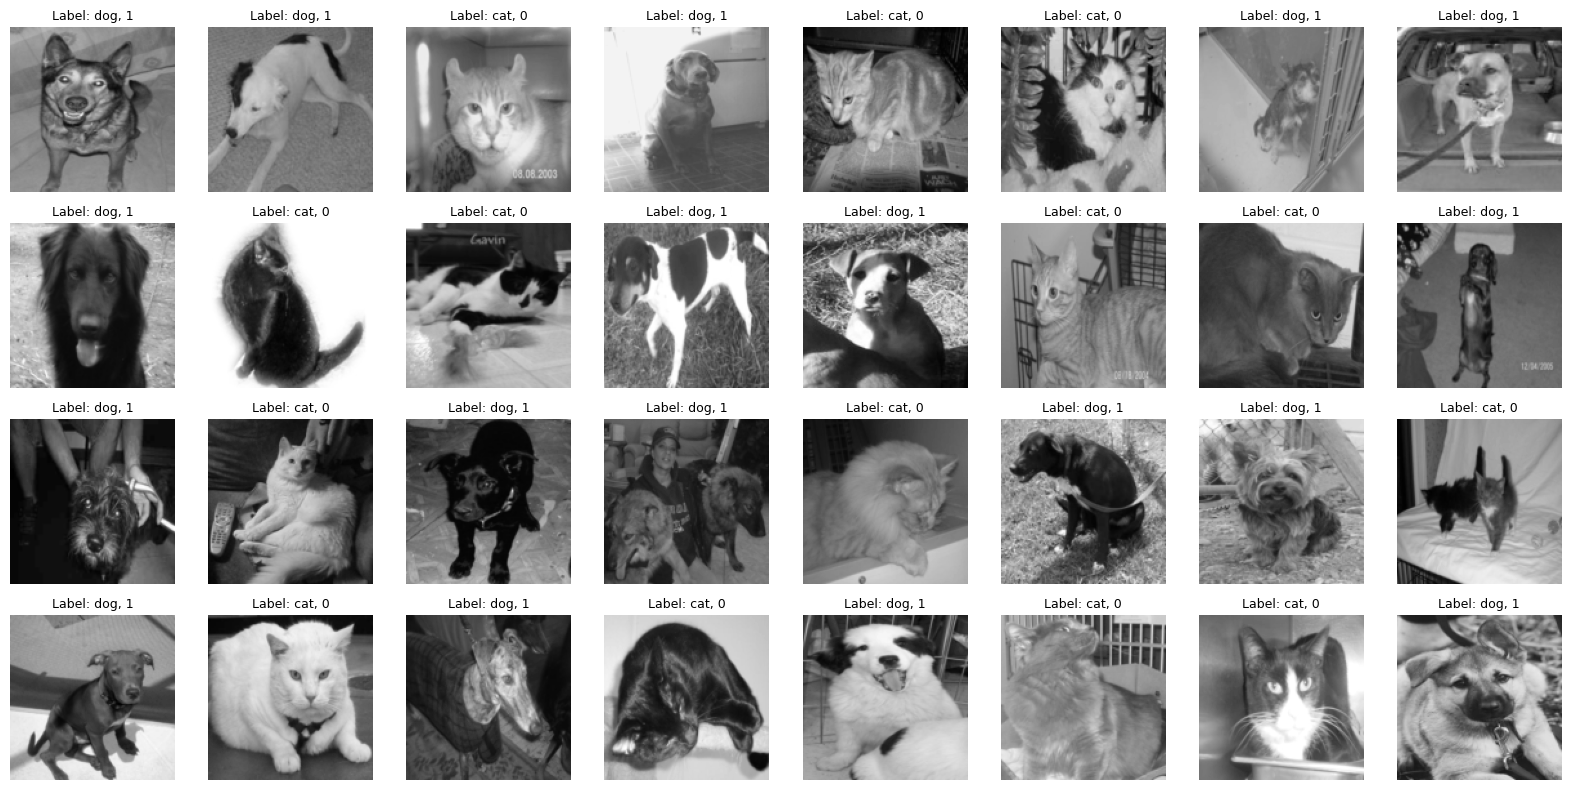

In [6]:
image, label = next(iter(test_loader))
description = label_map[label.to(int)]
show_selected_images_labels(image,label,description, rows=4, cols=8)

Takeaways and Notes
===
- The dataset appears diverse: different resolutions, angles, and poses.
- Some images are clearly distinguishable, while others are harder to classify due to poor quality or other objects in the image. Therefore, we should not expect perfect classification performance.

Additional Points to Consider
---
- Improve image preprocessing: consider resizing, cropping, or normalizing images to ensure consistency.
- Balance the dataset: if some classes are underrepresented, consider using oversampling or undersampling techniques.


The Bayesian Point of View – How Do We Define Our Classifier?
===
Let’s start by defining our task:
> Given a *single* image of a pet, we want to classify whether it shows a cat or a dog.

In more mathematical terms:
> Given a *single* image $x \in \mathbb{R}^{\text{width} \times \text{height}}$, we want to estimate the probabilities
$\mathbb{P}(x \text{ shows a cat})$ and $\mathbb{P}(x \text{ shows a dog})$. Since in our case, an image can either show a cat or a dog, it suffices to estimate one probability, e.g. $p = \mathbb{P}(x \text{ shows a dog})$. Afterwards, we immediately know the other probability since $\mathbb{P}(x \text{ shows a cat})=1-p$.

Even more mathematically:
> We want to learn a function $f: \mathbb{R}^{\text{width} \times \text{height}} \to [0,1]$ such that $f(x) \approx \mathbb{P}(x \text{ shows a dog})$.

But why are we talking about probabilities?
---
Let us assume we have a coin. But instead of the outcomes "head" or "number" the sides of our coin show a cat or a dog. Also, we do not expect to have a "fair" coin - maybe there are more cats out there than dogs.
Basically, the analogy of tossing our coin is that we choose randomly some pet (where according to some magic this is either a cat or dog) and then observe one of the two animals.
What is the probability that we see a dog?

First answer: how should we know?

Second answer: let us use our dataset! Count all the pictures showing a cat and divide by the total number of pictures - this gives us the sought probability.

In [7]:
labels = np.array(dataset.targets)

N = len(labels) # number of images in the dataset
dog_count = (labels == 1).sum() # number of dogs (by convention dogs have the label 1)
p_dog = dog_count / N
display(f"The probability of a randomly chosen image showing a dog is {100 * p_dog:.2f}%.")

'The probability of a randomly chosen image showing a dog is 50.00%.'

Now imagine we "toss the coin" again and draw another pet, named Alice. Before seeing her, we might assume a 50% chance she’s a dog.

But now we *see* Alice — she’s tall, has a big mouth — and our prior belief updates. With this information at hand, it seems ridiculous to still assume that there is only a 50% chance that Alice is a dog, right?

Updating the Probability
---
Previously, we computed $\mathbb{P}(\text{an image shows a dog}) \approx 0.50$ where we did not refer to an actual image. Now, we have a particular image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ observed. Let us say a picture of Alice. We want to calculate the probability that Alice is a dog, given the picture of her:
$$
\mathbb{P}(\text{Alice might be a dog} | \text{ a picture } x \text{ of Alice}) = ?
$$
The $$|\text{ a picture } x \text{ of Alice}$$ notation means that we now have this additional information of a picture of Alice.

Notes:
- We distinguish between “Alice is a dog” (an objective fact) and “we believe Alice is a dog” (a probabilistic estimate).
- We might misclassify e.g. due to a blurry image — this is a realistic source of error.

Mixing in Neural Networks
---
How would we, as humans, decide if Alice *is* a dog given the picture of her? We would conclude this because of the tail, the ears, ... The key idea:
> There are certain features in pictures of animals which belong only to one of the two classes.

Rather than hand-crafting features (which may be ineffective), we want the **network to learn them** from data.

Remember the function $f(x)\approx \mathbb{P}(x \text{ shows a dog})$ from before? Our $f(x)$ exactly is our neural network. Because we like fancy symbols, we do not write $f(x)$ but use the notation $\mathcal N_\theta(x)\approx \mathbb{P}(x \text{ shows a dog})$.

Convolutional Neural Networks
---
Our network $N_\theta(x)$ takes an image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ as input and gives us a probability as a number in $[0,1]$. Convolutional neural networks are exactly these type of networks which can reduce a whole image to a single number.

In [8]:
# Here we define the sketch of our (convolutional) neural network
use_sigmoid = False
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # These are convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                            

            nn.Conv2d(32, 64, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                            

            nn.Conv2d(64, 128, kernel_size=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2),                             
        )

        # These are fully connected layers
        if use_sigmoid:
            self.fc_layers = nn.Sequential(
                nn.Flatten(),                                
                nn.Linear(128 * 13 * 13, 32),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Linear(32, 1),
                nn.Sigmoid()                                  
            )
        else:
            self.fc_layers = nn.Sequential(
                nn.Flatten(),                                
                nn.Linear(128 * 13 * 13, 32),
                nn.LeakyReLU(),
                nn.Dropout(0.5),
                nn.Linear(32, 1),
                # the sigmoid is now included in the loss function for numerical stability
            )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Here we instantiate the neural network
neural_network = NeuralNetwork().to(device)

The Sigmoid Function
---
The last function of our network is the so-called sigmoid function
$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$
In 1D, $\sigma: \mathbb R \longrightarrow [0,1]$ which means in our case that $\sigma(t)$ can be interpreted as a probability!

Note however that $t \in \mathbb R$ here does not represent an image! Rather, $t$ is already an intermediate output of our neural network, which transformed an input image $x \in \mathbb{R}^{\text{width} \times \text{height}}$ to some arbitrary real number $t \in \mathbb R$ and then applies on top $\sigma(t)$ to get something in $[0,1]$.

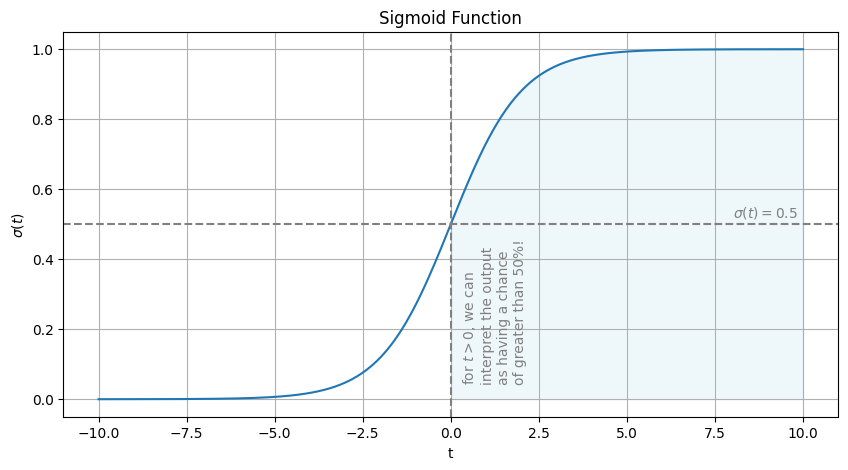

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Input range
t = np.linspace(-10, 10, 1000)
y = sigmoid(t)

# Plot
plt.figure(figsize=(10,5))
plt.plot(t, y)
plt.title("Sigmoid Function")
plt.xlabel("t")
plt.ylabel(r"$\sigma(t)$")
plt.grid(True)
plt.axhline(0.5, color='gray', linestyle='--')  # Midline
plt.axvline(0, color='gray', linestyle='--')    # Center point

# Annotate horizontal line
plt.text(8, 0.52, r"$\sigma(t)=0.5$", color='gray', fontsize=10)

# Annotate vertical line
plt.text(0.3, 0.05, 'for $t > 0$, we can \ninterpret the output \nas having a chance \nof greater than 50%!', color='gray', fontsize=10, rotation=90)

plt.fill_between(t, y, where=(t >= 0), color='lightblue', alpha=0.2, label=r'Area: $x \geq 0$')


plt.show()

Testing our Neural Network *before Training*
---
We can already plug in some images into our neural network and see what we get.

For this purpose we define the "accuracy" as the number of correctly classified pictures divided by the total number of pictures, i.e.
$$
\text{accuracy} = \frac{\text{\# correctly classified}}{\text{\# total}}
$$

In [10]:
# Here we define our accuracy function
decision_threshold = 0.5 if use_sigmoid else 0.0
def accuracy(model):
    # First we load a predefined set of test images and labels
    image, label = next(iter(test_loader))
    y_true = label.detach().cpu().numpy().squeeze()

    # Here we evaluate the model output on the test images
    with torch.no_grad():
        y_pred = (model(image.to(device)).detach().cpu().numpy() > decision_threshold).squeeze().astype(int)
    
    acc = (y_pred == y_true).mean()
    
    return acc, y_true, y_pred, image

# Just some visualisation
def eval_model(model):
    model.eval()

    acc, y_true, y_pred, image = accuracy(neural_network)
    
    visualize_predictions(image, y_true, y_pred, rows=4, cols=8)

    true_count = y_true == y_pred
    false_count = y_true != y_pred
    print("Correctly classified: ", np.sum(true_count))
    print("Wrongly classified: ", np.sum(false_count))
    print("Accuracy: ", acc)

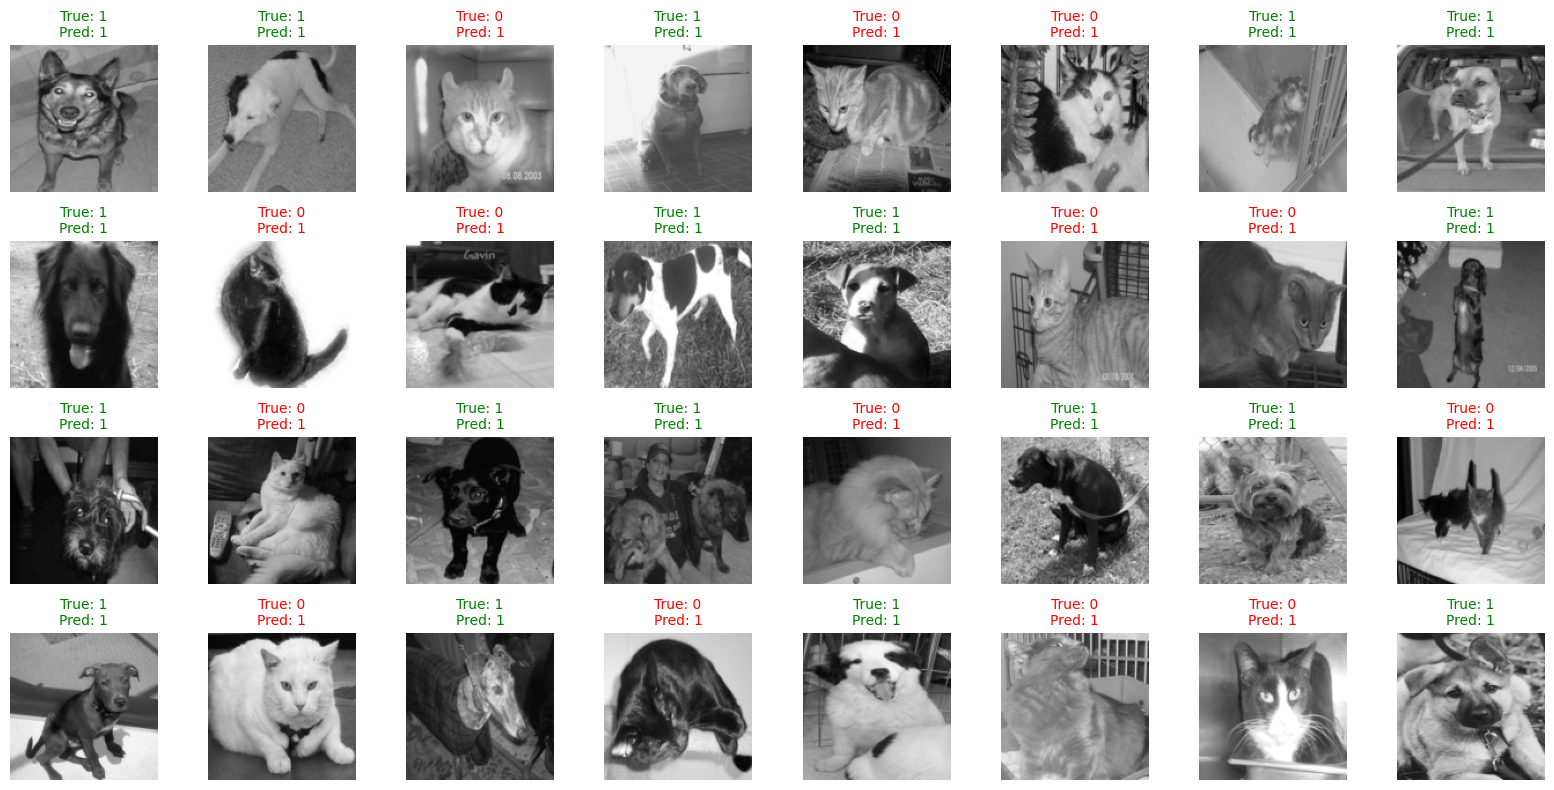

Correctly classified:  18
Wrongly classified:  14
Accuracy:  0.5625


In [11]:
eval_model(neural_network)

Training our Neural Network
===

So far it does not look like our network "knows" anything on how to classify correctly pets. Rather, it seems to randomly guess the type. We need to tell the network somehow how cats and dogs look like.

Learning by Examples
---
How did you "learn" how a dog looks like? I guess you have already seen enough dogs to know how they look. But not only this. When you really learned about pets like "This is Alice. She is a dog." you learned somehow from labelled data (you saw Alice with a description of her) and then were able to generalise to knew pets. This is exactly what we are now doing with our neural network.

In [12]:
# Here we define our loss function
if use_sigmoid:
    loss_func = nn.BCELoss().to(device)
else:
    # here we still use the sigmoid but it is hidden in the loss function
    loss_func = nn.BCEWithLogitsLoss().to(device)

# We tell the optimisation algorithm what parts of our neural network are trainable
pars = neural_network.parameters()
optimizer = torch.optim.Adam(pars, lr=0.0009, weight_decay=1e-5)

The Loss function
===
We have the convention that a 0 encodes cats and 1 encodes dogs. This are just labels and not probabilites! However, since our network outputs the probability $\mathcal N_\theta(x)\approx \mathbb{P}(x \text{ shows a dog})$ which should also be close to 0 if $x$ is a cat and close to 1 if $x$ is a dog, we can interchange the meaning of labels and probabilities.
If we have a pair $(x,l)$ where $x$ is an image (for example of Alice) and $l$ is the label, which is either 0 for cats and 1 for dogs, then we want to minimise
$$
|\mathcal N_\theta(x) - l|.
$$
in order to match the label $l$ of the image $x$.
If we have many of these image-label pairs, e.g. $(x_1, l_1), (x_2,l_2)$ then we want to minimise
$$
|\mathcal N_\theta(x_1) - l_1| + |\mathcal N_\theta(x_2) - l_2|.
$$
Here, $x_1$ might be an image of Alice where we already know that $l_1=1$ and $x_2$ an image of another pet, say Bob, where we know that $l_2=0$ meaning that Bob is a cat.

Of course, we have even more than two images for our training! To write this in a compact notation:
$$
\min \sum_{i=1,2,...,N} |\mathcal N_\theta(x_i) - l_i|
$$

Advanced: Rewriting the Loss Function
---
Since our model output $\mathcal N_\theta(x)$ is between 0 and 1, taking the logarithm would lead $-\infty$ if we are very certain that $x$ is a cat and $0$ if we are certain that $x$ is a dog. We want to investigate that further. Assume $x$ is a cat and therefore $l=0$. Let us have a look at the two terms
- $-l \cdot \log \mathcal N_\theta(x)$,
- $-(1-l) \cdot \log (1-\mathcal N_\theta(x))$.

If our network does a good job such that $\mathcal N_\theta(x) \approx 0$, then both terms are small (check it yourself!). However, if our network does a bad job, the second term will be really big.

Now assume that $x$ is a cat and $l=1$ and again look at the same terms
- $-l \cdot \log \mathcal N_\theta(x)$,
- $-(1-l) \cdot \log (1-\mathcal N_\theta(x))$.

Now, if our network classifies right such that $\mathcal N_\theta(x) \approx 1$ both terms will be small. If it does a bad job, then the first term will explode now!

In practice, this leads to the following loss function, called *binary cross entropy*:
$$
\min \sum_{i=1,2,...,N} -l \cdot \log \mathcal N_\theta(x)-(1-l) \cdot \log (1-\mathcal N_\theta(x))
$$

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/391 [00:00<?, ?batches/s]

/home/hoeflerm/.local/lib/python3.11/site-packages/PIL/TiffImagePlugin.py:868: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 2:   0%|          | 0/391 [00:00<?, ?batches/s]

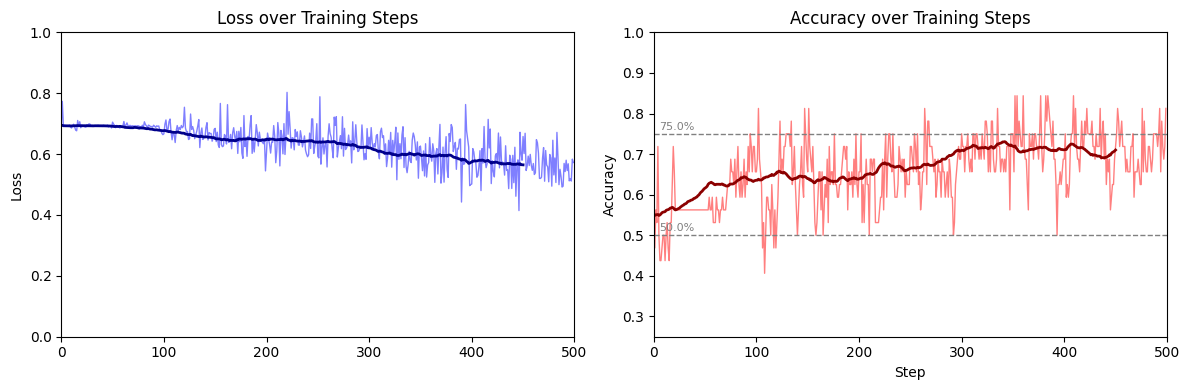

Epoch 3:   0%|          | 0/391 [00:00<?, ?batches/s]

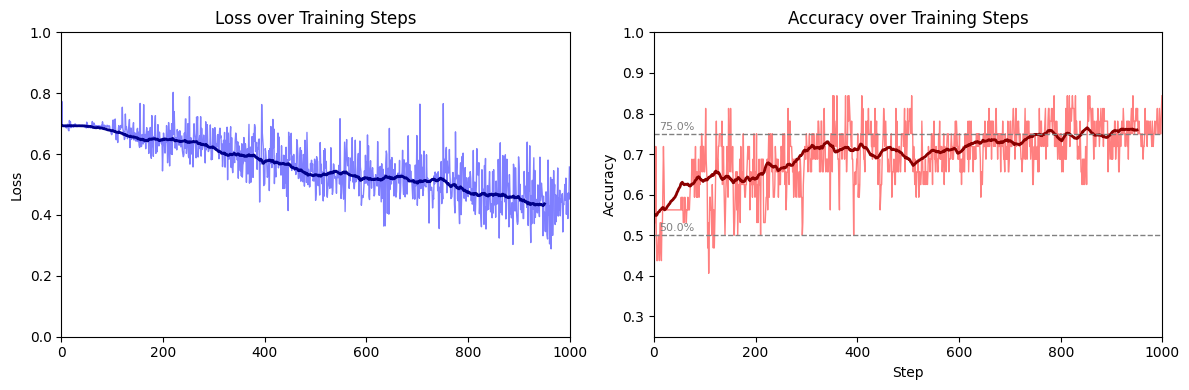

Epoch 4:   0%|          | 0/391 [00:00<?, ?batches/s]

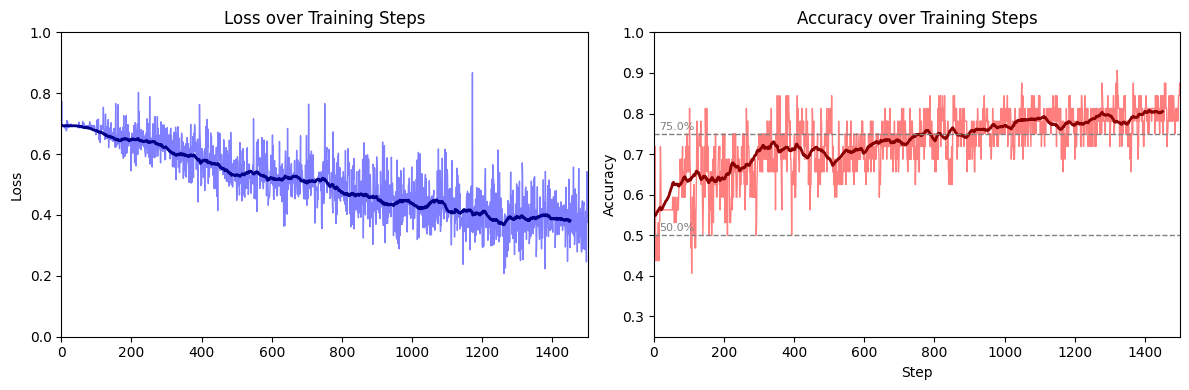

Epoch 5:   0%|          | 0/391 [00:00<?, ?batches/s]

Epoch 6:   0%|          | 0/391 [00:00<?, ?batches/s]

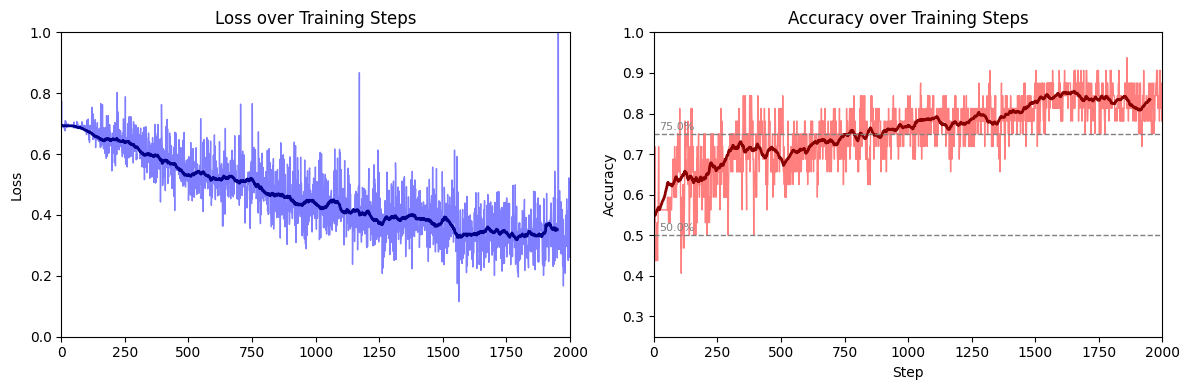

Epoch 7:   0%|          | 0/391 [00:00<?, ?batches/s]

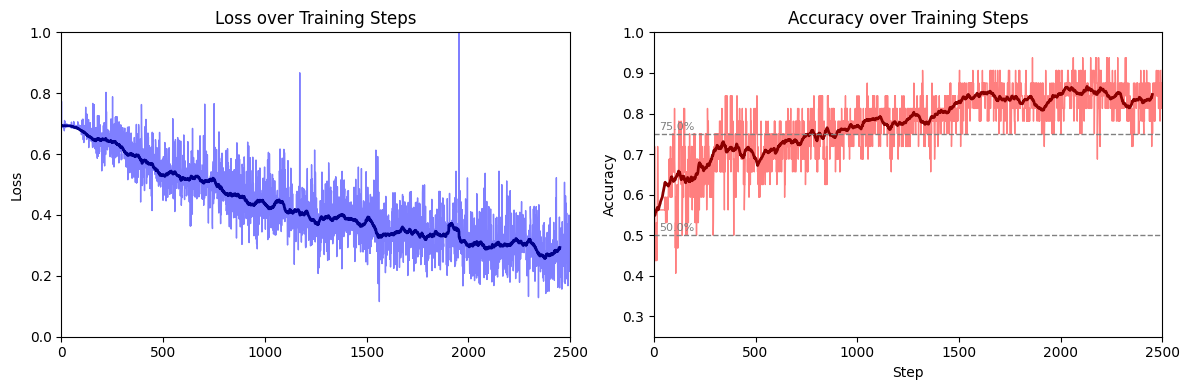

Epoch 8:   0%|          | 0/391 [00:00<?, ?batches/s]

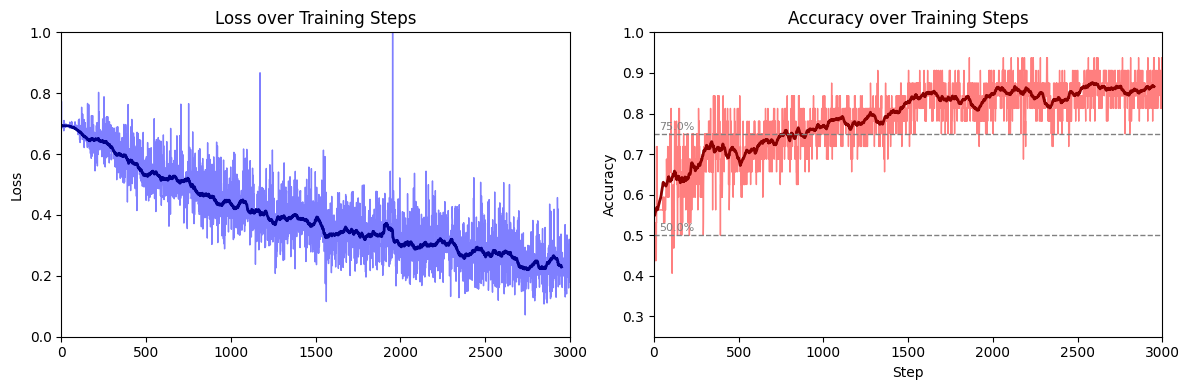

Epoch 9:   0%|          | 0/391 [00:00<?, ?batches/s]

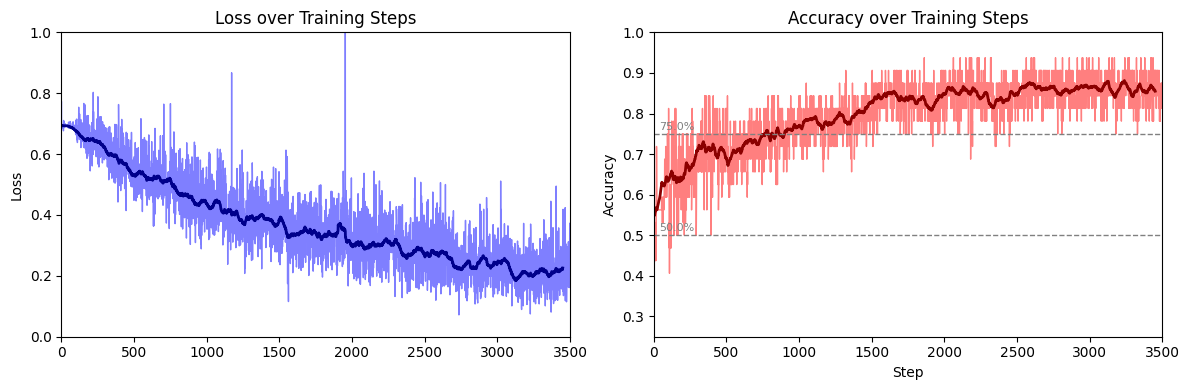

Epoch 10:   0%|          | 0/391 [00:00<?, ?batches/s]

Finished Training


In [13]:
# Some uninteresting setup code
epochs = 10
show_every=500

steps_per_epoch = len(train_loader)
ob_val = np.zeros(epochs*steps_per_epoch)
acc = np.zeros(epochs*steps_per_epoch)

epoch_bar = trange(epochs, desc="Epochs", leave=True) # just a fancy progress bar

i = 0

# The actual training of our neural network
neural_network.train() # set to training mode

# In each epoch, we loop over the whole dataset of approximately 20.000 images and labels
for epoch in epoch_bar:  

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", unit="batches", leave=False) # another fancy progress bar

    # Here we loop once over the whole dataset
    for images, labels in pbar:

        images = images.to(device)
        labels = labels.to(device)

        # start a new optimisation step
        optimizer.zero_grad()

        # Evaluate the loss and carry out gradient descent step
        loss = loss_func(neural_network(images).squeeze(),labels.to(torch.float32))
        loss.backward()

        # apply the update
        optimizer.step()


        
# Just some more uninteresting code
        # print loss
        ob_val[i] = loss.item()
        acc[i] = accuracy(neural_network)[0]

        pbar.set_postfix(loss=f"{ob_val[i]:.4f}", accuracy=f"{acc[i]:.4f}")

        if np.remainder(i,show_every)==0 and i > 0:
            plot_loss(ob_val[:i], acc[:i])
            plt.pause(0.001)

        i += 1
        avg_loss = ob_val[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch].mean()
        avg_acc = acc[epoch*steps_per_epoch:(epoch+1)*steps_per_epoch].mean()
    epoch_bar.set_postfix(avg_loss=f"{avg_loss:.4f}", accuracy=f"{avg_acc:.4f}")

print('Finished Training')

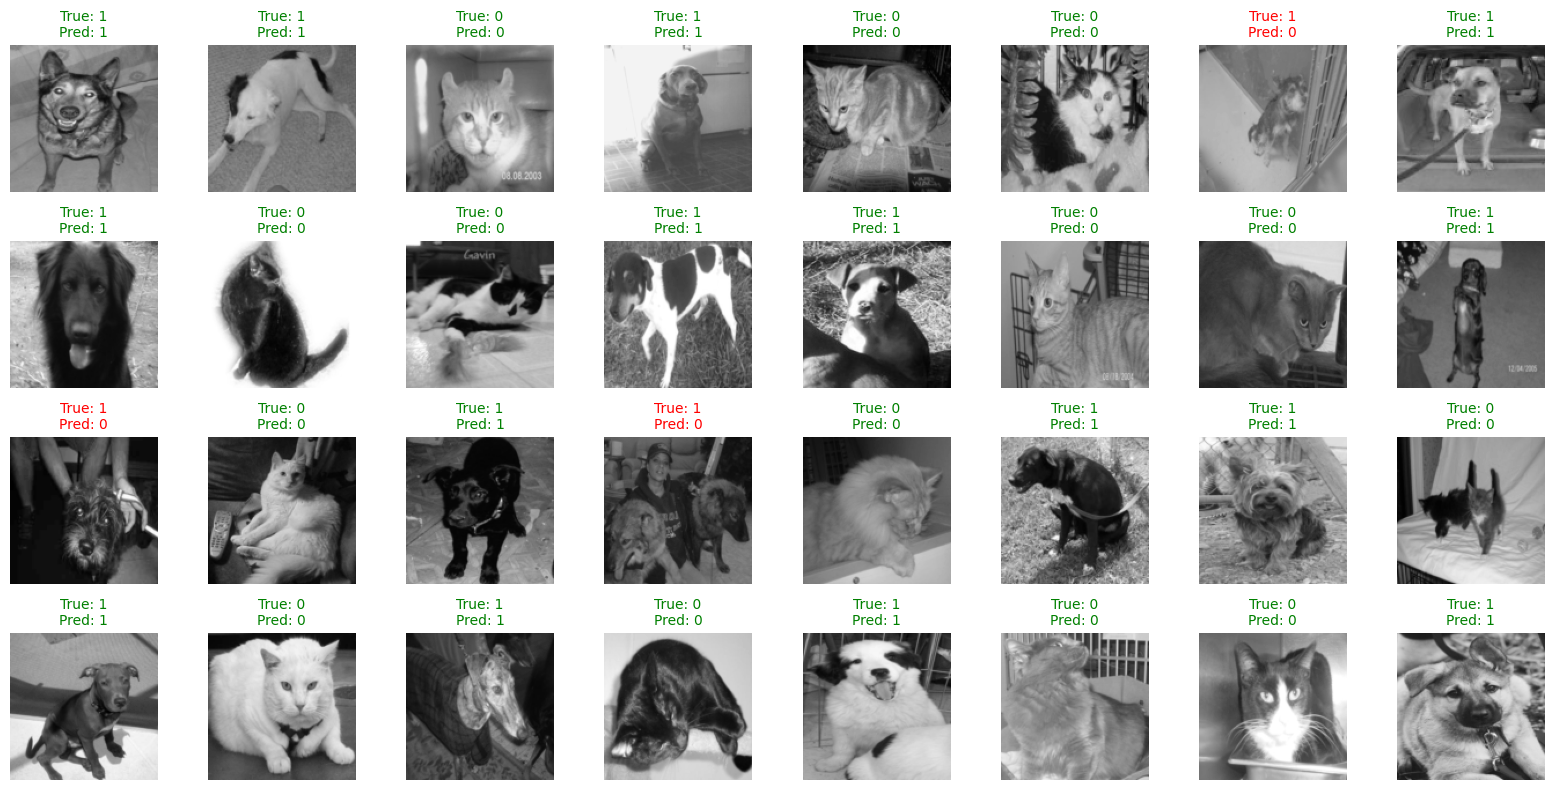

Correctly classified:  29
Wrongly classified:  3
Accuracy:  0.90625


In [14]:
# Make a post training check to see how our model has improved
eval_model(neural_network)